Imports and data.

In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
print('load data')
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)
reactions = dg.collection.ReactionCollection([dg.reaction.LazyReaction(r.template, id=r.id) for r in reactions])

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

load data


Define library designer.

In [2]:
from dgym.envs.library_designer import LibraryDesigner

library_designer = LibraryDesigner(
    reactions,
    building_blocks,
    fingerprints
)

Reconstruct a molecule as a generator.

### Construct logic of new Library Designer

In [3]:
import inspect
import random
from collections.abc import Iterator

def retrosynthesize(molecule, protect = False, max_depth = None, _depth = 0):
        
    # Base cases
    if _depth == max_depth:
        return molecule

    if isinstance(molecule, Iterator):
        return molecule
    
    if not molecule.reactants:
        return molecule
    
    # Recursive case: Retrosynthesize each reactant
    retrosynthesized_reactants = [
        retrosynthesize(reactant, protect, max_depth, _depth + 1)
        for reactant in molecule.reactants
    ]

    if molecule.reaction is None:
        molecule.reaction = library_designer.match_reactions(molecule)[0]

    # Use reaction to reconstruct the original molecule from its reactants
    output = molecule.reaction.run(retrosynthesized_reactants, protect=protect)
    
    return output

In [4]:
from dgym.envs.library_designer import AnalogGenerator

generator = AnalogGenerator(building_blocks, fingerprints)

CPU times: user 812 ms, sys: 0 ns, total: 812 ms
Wall time: 87.8 ms


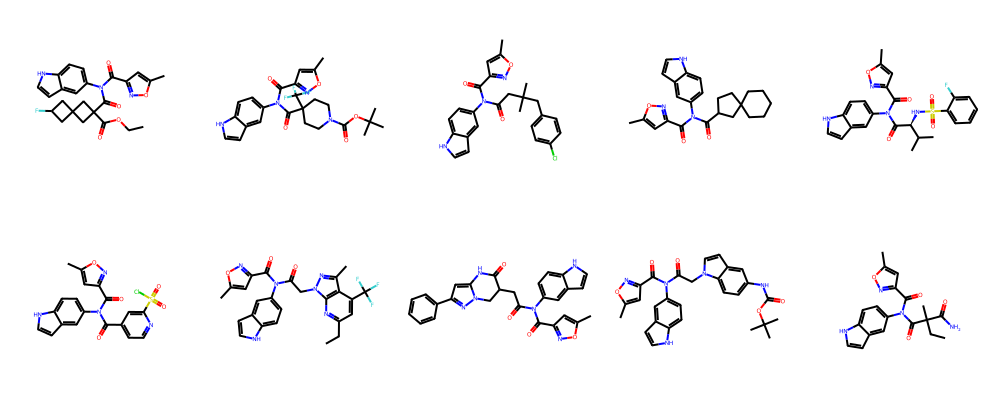

In [15]:
%%time
import itertools
from dgym.molecule import Molecule
from dgym.utils import ViewableGenerator

size = 10
molecule = deck[20]
mode = 'expand'

if mode == 'analog':
    reactions = library_designer.match_reactions(molecule)
    reactants = molecule.reactants
    reactants = [reactants[0], generator(reactants[1], temperature=0.0)]
    max_depth = None

elif mode == 'expand':
    reactions = library_designer.reactions
    reactants = [molecule, generator()]
    max_depth = 1
    
# Perform reactions
products = []
for reaction in reactions:

    if len(products) >= size:
        break

    with molecule.set_reaction(reaction):

        # Replace reactants with analog generators
        with molecule.set_reactants(reactants):
            
            # Lazy load molecule analogs
            analogs = retrosynthesize(molecule, protect=False, max_depth=max_depth)

            # Run reaction
            for analog in analogs:
                if len(products) < size:
                    products.append(analog)
                else:
                    break

from rdkit.Chem.Draw import MolsToGridImage
MolsToGridImage([p.mol for p in products], molsPerRow=5)